# Practice #4. "Dynamic predictive models. Part 2"

This notebook is dedicated to:
* Predicting Time series: Moving Average Model

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

## 0. Data reading and visualization

Please, specify path to data

In [32]:
path_to_datafile = "../data/airline-passengers.csv"

In [33]:
# data reading to pandas.DataFrame
df = pd.read_csv(path_to_datafile)

Please, rename time column to `ds` and data column to `y`(you can use `df.rename`) . If use dataset with multiple features select only one and drop NaN values

In [34]:
# your code here
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)


Convert date column to datetime format and set as index

In [35]:
df["ds"] = pd.to_datetime(df["ds"])
df.set_index("ds", inplace=True)

Number of data data points:

In [36]:
df.shape[0]

144

Print slice of the timeseries:

In [37]:
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let's plot the data

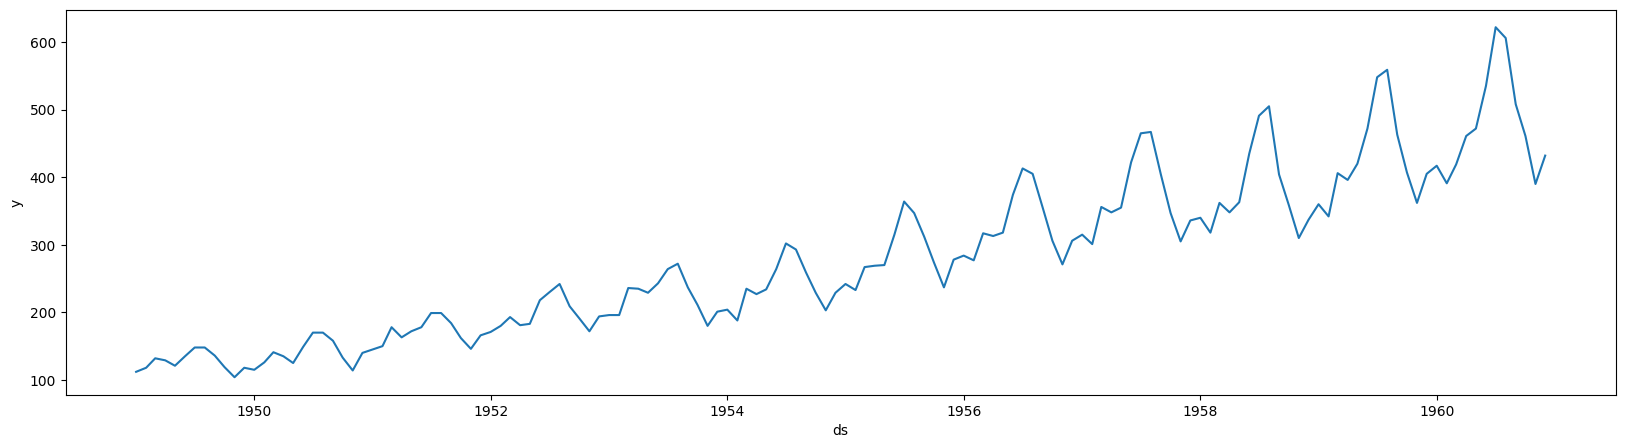

In [38]:
plt.figure(figsize=(20, 5))
plt.ylabel("y")
plt.xlabel("ds")
plt.plot(df);

## 1. Predicting Time series: Moving Average Model

The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves from a time series that can have a temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing. The difference between what was ground truth and what was predicted is called the residual error.<br>
Just like the input observations themselves, the residual errors from a time series can have a temporal structure like trends, bias, and seasonality. Any temporal structure in the time series of residual forecast errors is useful as a diagnostic as it suggests information that could be incorporated into the predictive model. An ideal model would leave no structure in the residual error, just random fluctuations that cannot be modeled.
Structure in the residual error can also be modeled directly. There may be complex signals in the residual error that are difficult to directly incorporate into the model. Instead, you can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn, provide an additional lift in performance.

Split data on train and test set.

In [39]:
# your code here
train_size = int(len(df) * 0.80)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

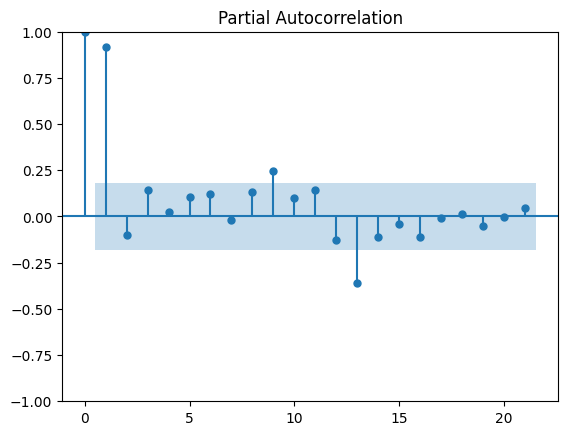

In [40]:
plot_pacf(df_train['y']);

Please, calculate residual error using AR model and train set.

In [41]:
#your code here
model = AutoReg(df_train['y'], lags=5, trend='t', seasonal=True, period=12).fit()
df_forecast = model.fittedvalues

residual_error = df_train['y'] - df_forecast

print(residual_error)

ds
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
                ...    
1958-03-01     4.856645
1958-04-01   -12.851448
1958-05-01     6.268713
1958-06-01    24.477658
1958-07-01    18.081987
Length: 115, dtype: float64


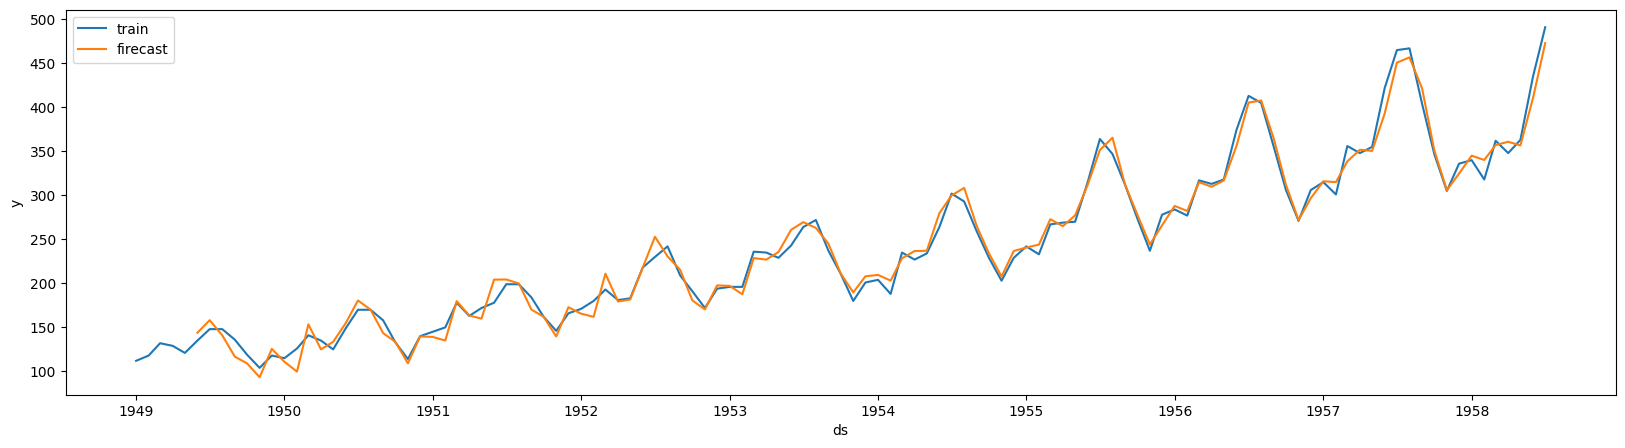

In [42]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_forecast, label='firecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Please, train AR model for residual error

In [43]:
# youre code here
residual_model = AutoReg(residual_error.dropna(), lags=5).fit()
re_forecast = residual_model.fittedvalues

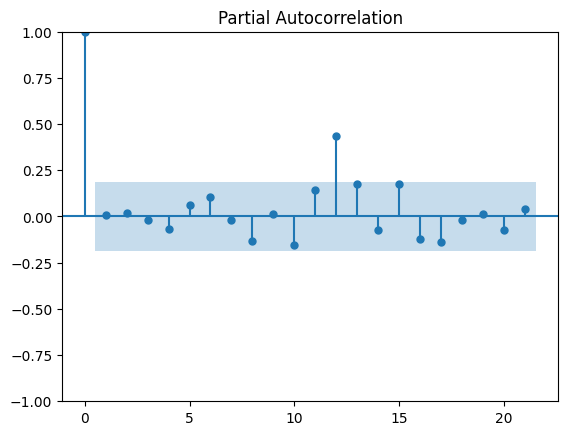

In [44]:
plot_pacf(residual_error.dropna());

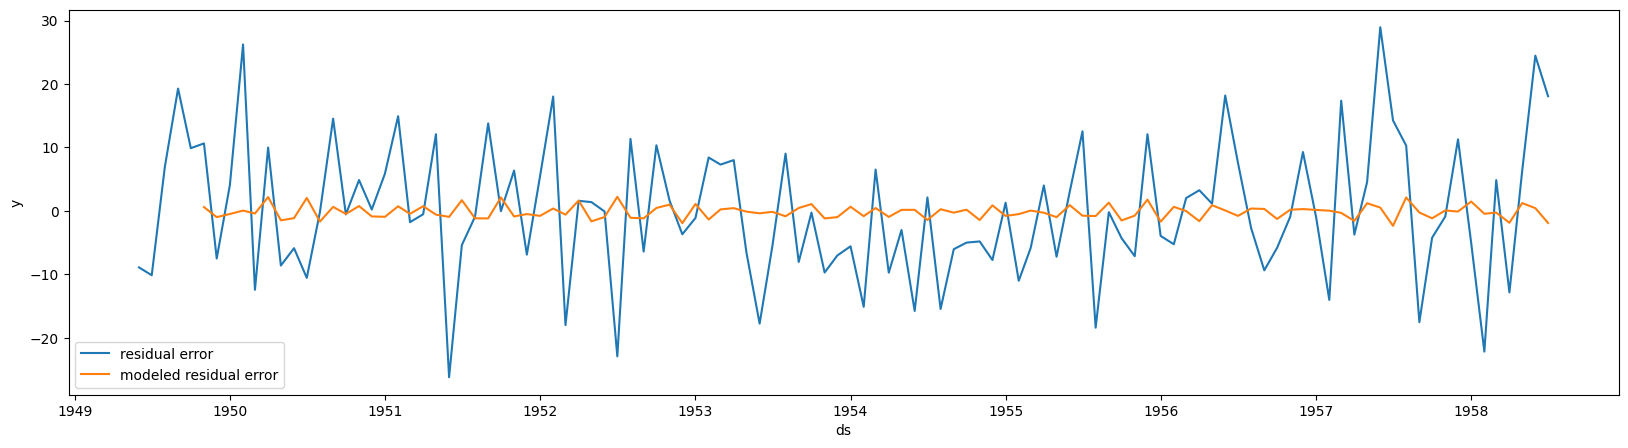

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(residual_error, label='residual error')
plt.plot(re_forecast, label='modeled residual error')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Now correct predictions with a AR model of residuals. With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.
$$\textit{improved forecast = forecast + estimated error}$$

In [46]:
# your code here
forecast_steps = len(df_test)
forecast = model.predict(start=len(df_train), end=len(df_train) + forecast_steps - 1)
re_forecast = residual_model.predict(start=len(df_train), end=len(df_train) + forecast_steps - 1)

corrected_forecast = df_test.copy()
corrected_forecast['y'] = forecast[-forecast_steps:].values + re_forecast[-forecast_steps:].values

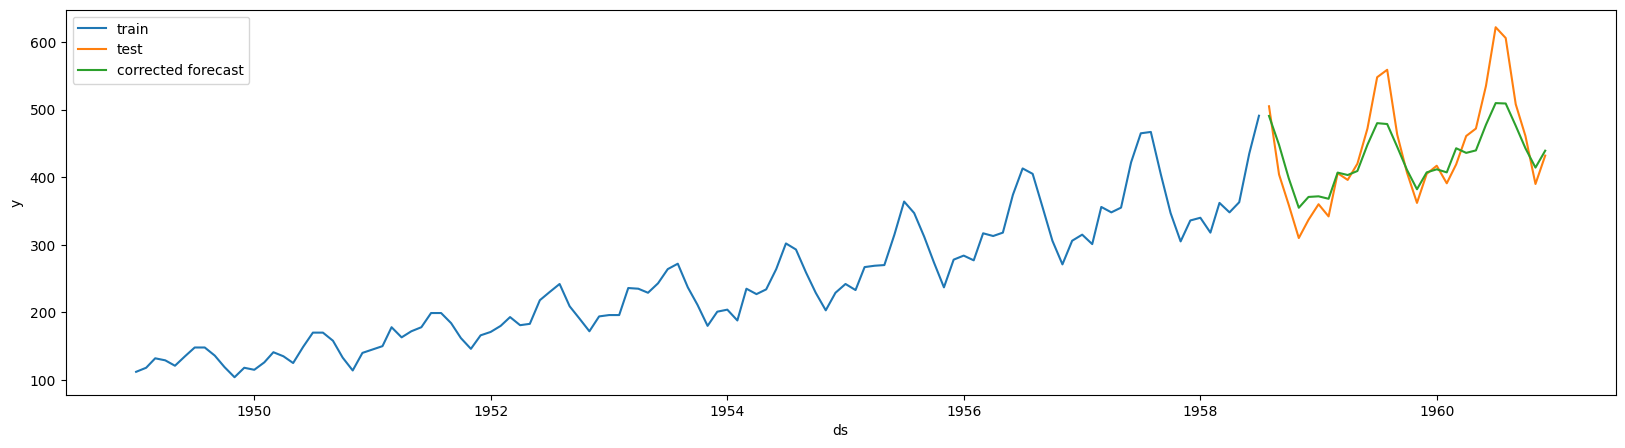

In [47]:
plt.figure(figsize=(20, 5))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.plot(corrected_forecast, label='corrected forecast')
plt.ylabel("y")
plt.xlabel("ds")
plt.legend();

Moved Average model RMSE:

In [48]:
np.sqrt(mean_squared_error(df_test['y'], corrected_forecast))

41.535470834492116